#  NYC House Price Prediction

This project predicts real estate prices for NYC properties using a stacked machine learning model that combines **XGBoost** and **Random Forest** with a **Ridge Regression** meta-learner. The app is served via **Streamlit**, includes **SHAP** model interpretability, and is trained on a curated and feature-engineered dataset.


In [4432]:
import numpy as np
import opendatasets as od
import os

In [4433]:
dataset_url = 'https://www.kaggle.com/datasets/nelgiriyewithana/new-york-housing-market'
datadir = 'new-york-housing-market'
od.download(dataset_url)
os.listdir(datadir)

Skipping, found downloaded files in "./new-york-housing-market" (use force=True to force download)


['NY-House-Dataset.csv']

## FEATURE ENGINEERING

In [4434]:
import pandas as pd

df = pd.read_csv(os.path.join(datadir, 'NY-House-Dataset.csv'))
df.head(10)

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.000000,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856
5,Brokered by Sowae Corp,House for sale,690000,5,2.000000,4004.000000,584 Park Pl,"Brooklyn, NY 11238","584 Park PlBrooklyn, NY 11238",United States,New York,Kings County,Brooklyn,Park Place,"584 Park Pl, Brooklyn, NY 11238, USA",40.674363,-73.958725
6,Brokered by Douglas Elliman - 575 Madison Ave,Condo for sale,899500,2,2.000000,2184.207862,157 W 126th St Unit 1B,"New York, NY 10027","157 W 126th St Unit 1BNew York, NY 10027",New York,New York County,New York,Manhattan,157,"157 W 126th St #1b, New York, NY 10027, USA",40.809448,-73.946777
7,Brokered by Connie Profaci Realty,House for sale,16800000,8,16.000000,33000.000000,177 Benedict Rd,"Staten Island, NY 10304","177 Benedict RdStaten Island, NY 10304",United States,New York,Richmond County,Staten Island,Benedict Road,"177 Benedict Rd, Staten Island, NY 10304, USA",40.595002,-74.106424
8,Brokered by Pantiga Group Inc.,Co-op for sale,265000,1,1.000000,750.000000,875 Morrison Ave Apt 3M,"Bronx, NY 10473","875 Morrison Ave Apt 3MBronx, NY 10473",Bronx County,The Bronx,East Bronx,Morrison Avenue,Parking lot,"Parking lot, 875 Morrison Ave #3m, Bronx, NY 1...",40.821586,-73.874089
9,Brokered by CENTURY 21 MK Realty,Co-op for sale,440000,2,1.000000,978.000000,1350 Ocean Pkwy Apt 5G,"Brooklyn, NY 11230","1350 Ocean Pkwy Apt 5GBrooklyn, NY 11230",New York,Kings County,Brooklyn,Midwood,1350,"1350 Ocean Pkwy #5g, Brooklyn, NY 11230, USA",40.615738,-73.969694


In [4435]:
df.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.946962,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


In [4436]:
df['PRICE'].sort_values(ascending=False)

304     2147483647
1        195000000
69        65000000
1075      60000000
141       56000000
           ...    
979          60000
463          49500
360           5800
310           3225
317           2494
Name: PRICE, Length: 4801, dtype: int64

In [4437]:
df['PRICE'].sort_values(ascending=True)

317           2494
310           3225
360           5800
463          49500
979          60000
           ...    
141       56000000
1075      60000000
69        65000000
1        195000000
304     2147483647
Name: PRICE, Length: 4801, dtype: int64

In [4438]:
df.drop([304,1,317,310,360,463], inplace=True)

In [4439]:
df['BEDS'].sort_values(ascending=False)

1143    50
2653    42
3276    40
2488    36
765     35
        ..
1579     1
2743     1
3622     1
1573     1
4800     1
Name: BEDS, Length: 4795, dtype: int64

In [4440]:
df['BEDS'].sort_values(ascending=True)

4800     1
3526     1
3525     1
3523     1
3520     1
        ..
765     35
2488    36
3276    40
2653    42
1143    50
Name: BEDS, Length: 4795, dtype: int64

In [4441]:
df.drop([1143, 2653, 3276,2488,765,2265,3589,3603,4240,2564,1092,1410,1214,750,4191,4404], inplace=True)

In [4442]:
df['BATH'].sort_values(ascending=False)

622     32.0
4691    17.0
936     16.0
7       16.0
631     13.0
        ... 
2820     1.0
4800     1.0
2699     0.0
3379     0.0
2704     0.0
Name: BATH, Length: 4779, dtype: float64

In [4443]:
df['BATH'].sort_values(ascending=True)

2699     0.0
2704     0.0
3379     0.0
3318     1.0
1384     1.0
        ... 
631     13.0
7       16.0
936     16.0
4691    17.0
622     32.0
Name: BATH, Length: 4779, dtype: float64

In [4444]:
df.drop([622, 4691,936,7,631,1825,2076,1072,4745,1395,3379,2704,2699], inplace=True)
df['BATH'].sort_values(ascending=False)

141     10.0
1136    10.0
1815    10.0
270     10.0
1835    10.0
        ... 
2607     1.0
2603     1.0
2602     1.0
2601     1.0
4800     1.0
Name: BATH, Length: 4766, dtype: float64

In [4445]:
df['PROPERTYSQFT'].sort_values(ascending=False)

4623    65535.0
2146    55300.0
2148    55300.0
823     48000.0
3130    32000.0
         ...   
1494      260.0
2166      250.0
332       250.0
4693      246.0
188       230.0
Name: PROPERTYSQFT, Length: 4766, dtype: float64

In [4446]:
df['PROPERTYSQFT'].sort_values(ascending=True)

188       230.0
4693      246.0
332       250.0
2166      250.0
1494      260.0
         ...   
3130    32000.0
823     48000.0
2146    55300.0
2148    55300.0
4623    65535.0
Name: PROPERTYSQFT, Length: 4766, dtype: float64

In [4447]:
df.drop([4623,2146,2148,823,3130,141,2932,2054,917,1823,4353,2107,69,4,2171], inplace=True)

In [4448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4751 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4751 non-null   object 
 1   TYPE                         4751 non-null   object 
 2   PRICE                        4751 non-null   int64  
 3   BEDS                         4751 non-null   int64  
 4   BATH                         4751 non-null   float64
 5   PROPERTYSQFT                 4751 non-null   float64
 6   ADDRESS                      4751 non-null   object 
 7   STATE                        4751 non-null   object 
 8   MAIN_ADDRESS                 4751 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4751 non-null   object 
 10  LOCALITY                     4751 non-null   object 
 11  SUBLOCALITY                  4751 non-null   object 
 12  STREET_NAME                  4751 non-null   object 
 13  LONG_NAME              

In [4449]:
print(f"number of rows in the dataset is {df.shape[0]}")

number of rows in the dataset is 4751


In [4450]:
df.isna().sum()

BROKERTITLE                    0
TYPE                           0
PRICE                          0
BEDS                           0
BATH                           0
PROPERTYSQFT                   0
ADDRESS                        0
STATE                          0
MAIN_ADDRESS                   0
ADMINISTRATIVE_AREA_LEVEL_2    0
LOCALITY                       0
SUBLOCALITY                    0
STREET_NAME                    0
LONG_NAME                      0
FORMATTED_ADDRESS              0
LATITUDE                       0
LONGITUDE                      0
dtype: int64

In [4451]:
df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.0,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
2,Brokered by Sowae Corp,House for sale,260000,4,2.0,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.0,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
5,Brokered by Sowae Corp,House for sale,690000,5,2.0,4004.000000,584 Park Pl,"Brooklyn, NY 11238","584 Park PlBrooklyn, NY 11238",United States,New York,Kings County,Brooklyn,Park Place,"584 Park Pl, Brooklyn, NY 11238, USA",40.674363,-73.958725
6,Brokered by Douglas Elliman - 575 Madison Ave,Condo for sale,899500,2,2.0,2184.207862,157 W 126th St Unit 1B,"New York, NY 10027","157 W 126th St Unit 1BNew York, NY 10027",New York,New York County,New York,Manhattan,157,"157 W 126th St #1b, New York, NY 10027, USA",40.809448,-73.946777


In [4452]:
df.drop(['ADDRESS','MAIN_ADDRESS','ADMINISTRATIVE_AREA_LEVEL_2','STREET_NAME', 'LONG_NAME', 'FORMATTED_ADDRESS','LONGITUDE', 'LATITUDE','BROKERTITLE','SUBLOCALITY'], axis=1, inplace=True)
df.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,STATE,LOCALITY
0,Condo for sale,315000,2,2.0,1400.000000,"New York, NY 10022",New York
2,House for sale,260000,4,2.0,2015.000000,"Staten Island, NY 10312",New York
3,Condo for sale,69000,3,1.0,445.000000,"Manhattan, NY 10022",New York
5,House for sale,690000,5,2.0,4004.000000,"Brooklyn, NY 11238",New York
6,Condo for sale,899500,2,2.0,2184.207862,"New York, NY 10027",New York County


In [4453]:
print(f"number of rows in the dataset is {df.shape[0]}")

number of rows in the dataset is 4751


In [4454]:
df['TYPE'] = df['TYPE'].str.split('for', expand=True)[0]

In [4455]:
df['BATH'] = df['BATH'].astype(int)

In [4456]:
df['PROPERTYSQFT'] = df['PROPERTYSQFT'].astype(int)

In [4457]:
df['ZIP'] = df['STATE'].str.split(',', expand=True)[1].str.split('NY', expand=True)[1].astype(int)
df['STATE'] = df['STATE'].str.split(',', expand=True)[0]

In [4458]:
df.head()

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,STATE,LOCALITY,ZIP
0,Condo,315000,2,2,1400,New York,New York,10022
2,House,260000,4,2,2015,Staten Island,New York,10312
3,Condo,69000,3,1,445,Manhattan,New York,10022
5,House,690000,5,2,4004,Brooklyn,New York,11238
6,Condo,899500,2,2,2184,New York,New York County,10027


### DATA VISUALIZATION

In [4459]:
import matplotlib.pyplot as plt
import seaborn as sns

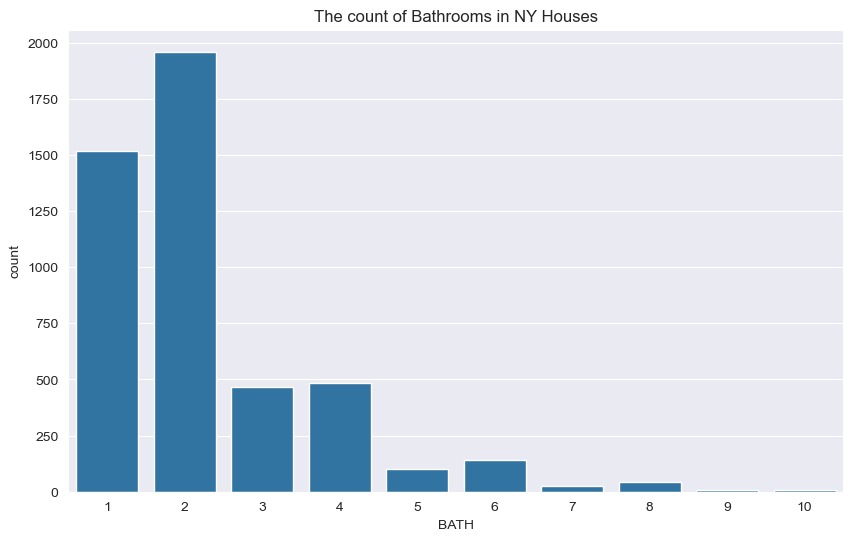

In [4460]:
plt.figure(figsize=(10,6))
sns.countplot(x='BATH', data=df)
plt.title("The count of Bathrooms in NY Houses")
plt.show()

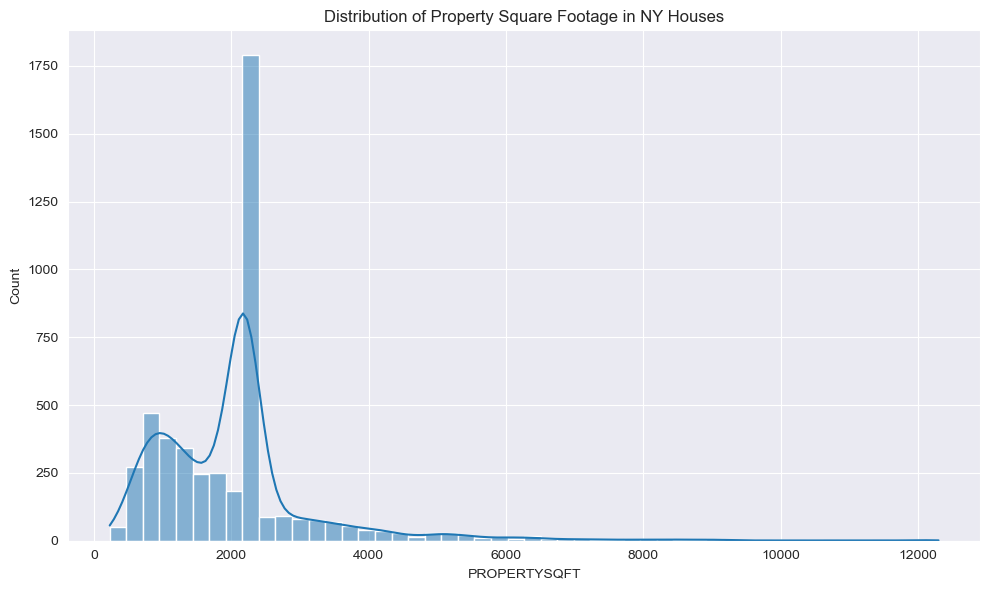

In [4461]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='PROPERTYSQFT', bins=50, kde=True)
plt.title("Distribution of Property Square Footage in NY Houses")
plt.tight_layout()
plt.show()

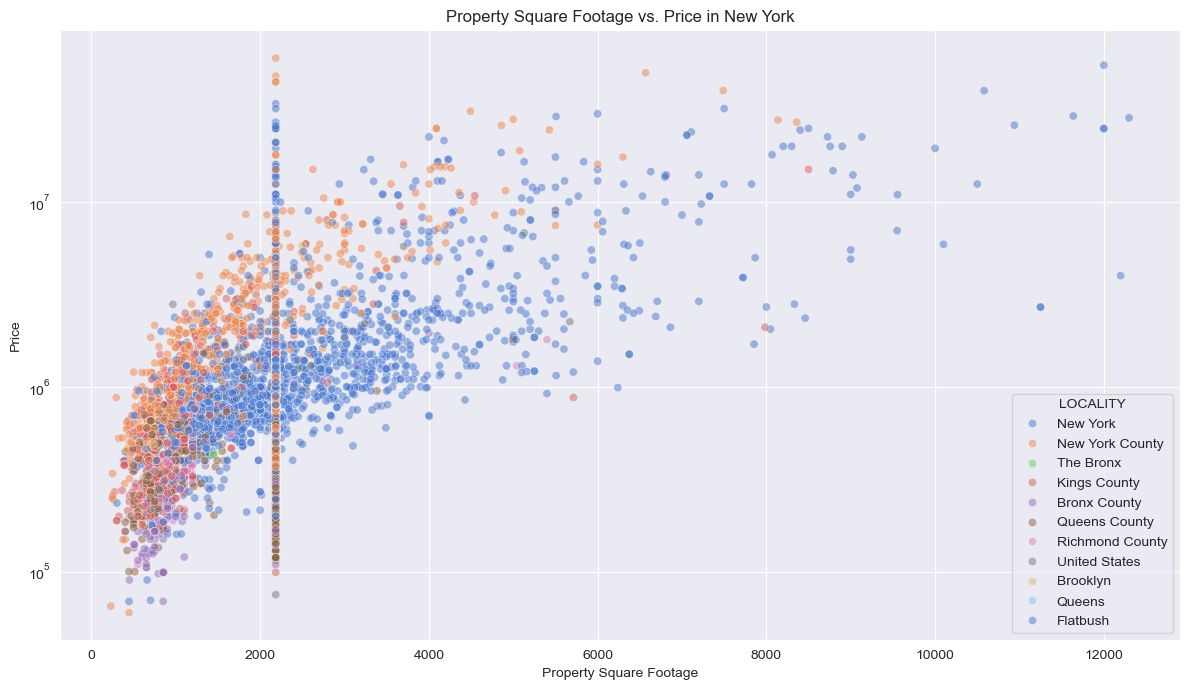

In [4462]:
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x='PROPERTYSQFT',
    y='PRICE',
    hue='LOCALITY',
    alpha=0.5,
    palette='muted'
)
plt.title("Property Square Footage vs. Price in New York")
plt.xlabel("Property Square Footage")
plt.ylabel("Price")
plt.yscale('log')
plt.tight_layout()
plt.show()

In [4463]:
type_order = df.groupby('TYPE')['PRICE'].mean().sort_values(ascending=False).index

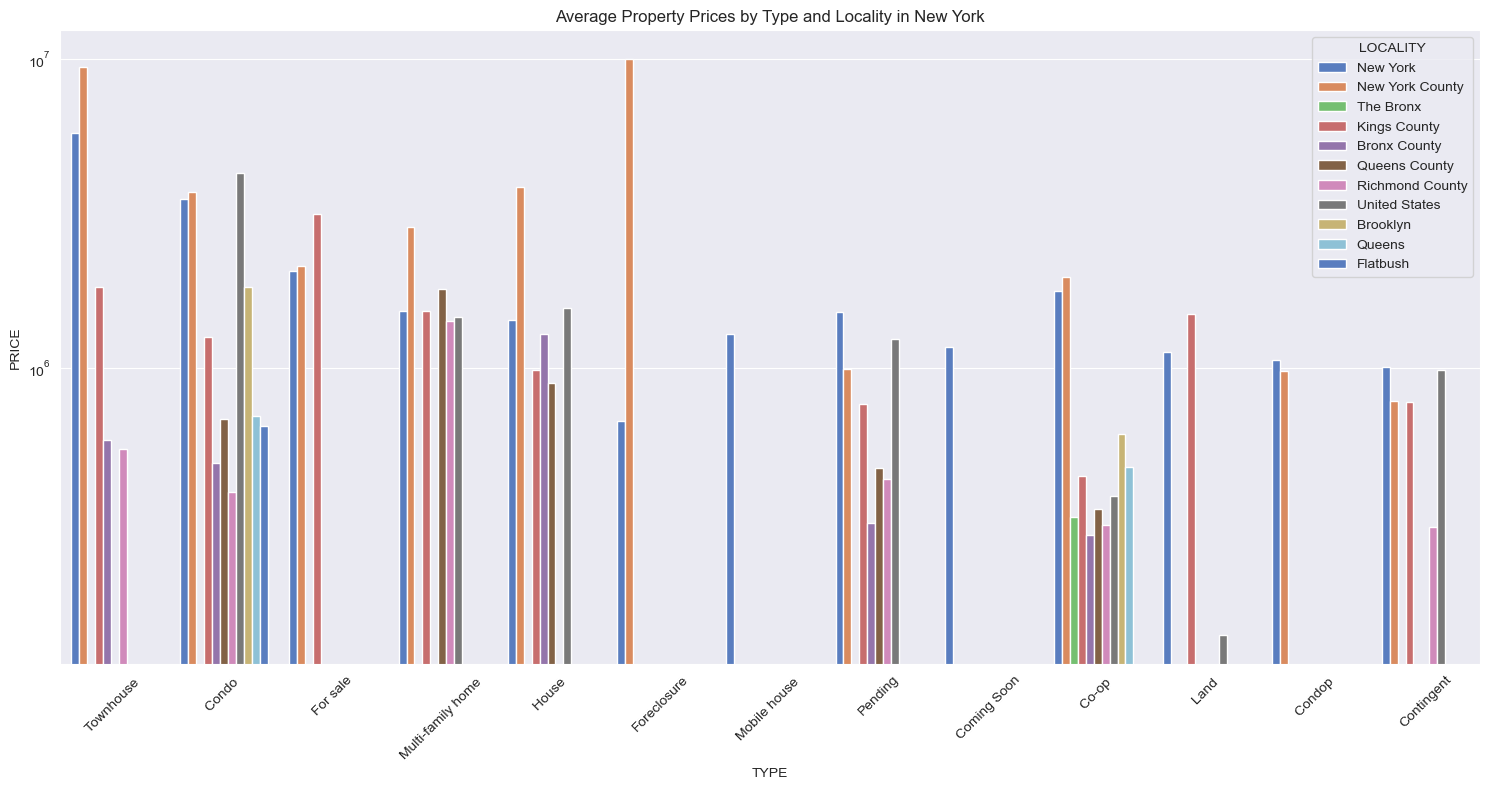

In [4464]:
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='TYPE', y='PRICE', hue='LOCALITY', errorbar=None, order=type_order, palette='muted')
plt.title("Average Property Prices by Type and Locality in New York")
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [4465]:
df.head(50)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,STATE,LOCALITY,ZIP
0,Condo,315000,2,2,1400,New York,New York,10022
2,House,260000,4,2,2015,Staten Island,New York,10312
3,Condo,69000,3,1,445,Manhattan,New York,10022
5,House,690000,5,2,4004,Brooklyn,New York,11238
6,Condo,899500,2,2,2184,New York,New York County,10027
8,Co-op,265000,1,1,750,Bronx,The Bronx,10473
9,Co-op,440000,2,1,978,Brooklyn,Kings County,11230
10,Co-op,375000,2,1,850,Bronx,Bronx County,10451
11,Townhouse,689000,3,2,1162,Staten Island,New York,10303
12,Co-op,259000,3,1,2184,Jackson Heights,Queens County,11372


In [4466]:
df.isnull().sum()

TYPE            0
PRICE           0
BEDS            0
BATH            0
PROPERTYSQFT    0
STATE           0
LOCALITY        0
ZIP             0
dtype: int64

In [4467]:
df.isnull().sum()

TYPE            0
PRICE           0
BEDS            0
BATH            0
PROPERTYSQFT    0
STATE           0
LOCALITY        0
ZIP             0
dtype: int64

In [4468]:
df = df[df['PRICE'] <= 1e7]
price_cap = df['PRICE'].quantile(0.99)
df = df[df['PRICE'] <= price_cap]

In [4469]:
df['PRICE_PER_BATH'] = df['PRICE'] // df['BATH'].replace(0, 1)

In [4470]:
df['SQFT_PER_BED'] = df['PROPERTYSQFT'] / df['BEDS'].replace(0, 1)
df['SQFT_PER_BATH'] = df['PROPERTYSQFT'] / df['BATH'].replace(0, 1)

In [4471]:
df['IS_LUXURY'] = (df['PRICE'] > 2_000_000).astype(int)

In [4472]:
df['LARGE_HOME'] = (df['PROPERTYSQFT'] > 2500).astype(int)

In [4473]:
df.drop(['STATE','TYPE'], axis=1, inplace=True)

### ADDITIONAL FEATURE

You can use the haversine library to find out the proximity of houses from their given latitudes & longitudes, subsequently create 4 different features per each row.

__Caution__: While this technique might be useful in some cases, it might lead to degradations in the model performance.

In [4474]:
!pip install haversine --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4475]:
from haversine import haversine, Unit

landmark_coords = [
    ("Times Square",       40.7580, -73.9855),
    ("Central Park",       40.7829, -73.9654),
    ("Wall Street",        40.7060, -74.0086),
    ("JFK Airport",        40.6413, -73.7781),
]

# for landmark, lat, lon in landmark_coords:
#    col_name = 'DIST_TO_' + landmark.upper().replace(" ", "_") + '_MILES'
#    df[col_name] = df.apply(
#        lambda row: haversine((row['LATITUDE'], row['LONGITUDE']), (lat, lon), unit=Unit.MILES),
#        axis=1
#    )
# df.drop(['LATITUDE', 'LONGITUDE'], axis=1, inplace=True)

In [4476]:
df.head()

,PRICE,BEDS,BATH,PROPERTYSQFT,LOCALITY,ZIP,PRICE_PER_BATH,SQFT_PER_BED,SQFT_PER_BATH,IS_LUXURY,LARGE_HOME
0,315000,2,2,1400,New York,10022,157500,700.000000,700.0,0,0
2,260000,4,2,2015,New York,10312,130000,503.750000,1007.5,0,0
3,69000,3,1,445,New York,10022,69000,148.333333,445.0,0,0
5,690000,5,2,4004,New York,11238,345000,800.800000,2002.0,0,1
6,899500,2,2,2184,New York County,10027,449750,1092.000000,1092.0,0,0


## DATASET PREPARATION

In [4477]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

X = df.drop('PRICE', axis=1)
y = df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_columns = X.select_dtypes(include='object').columns.tolist()
numeric_columns = X.select_dtypes(exclude='object').columns.tolist()

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[categorical_columns])

X_train_cat = ohe.transform(X_train[categorical_columns])
X_test_cat = ohe.transform(X_test[categorical_columns])

encoded_categorical_columns = ohe.get_feature_names_out(categorical_columns)

X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoded_categorical_columns, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=encoded_categorical_columns, index=X_test.index)

X_train_num_df = X_train[numeric_columns].reset_index(drop=True)
X_test_num_df = X_test[numeric_columns].reset_index(drop=True)

X_train_final = pd.concat([X_train_num_df, X_train_cat_df.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df.reset_index(drop=True)], axis=1)

In [4478]:
X_train_final.columns

Index(['BEDS', 'BATH', 'PROPERTYSQFT', 'ZIP', 'PRICE_PER_BATH', 'SQFT_PER_BED',
       'SQFT_PER_BATH', 'IS_LUXURY', 'LARGE_HOME', 'LOCALITY_Bronx County',
       'LOCALITY_Brooklyn', 'LOCALITY_Kings County', 'LOCALITY_New York',
       'LOCALITY_New York County', 'LOCALITY_Queens', 'LOCALITY_Queens County',
       'LOCALITY_Richmond County', 'LOCALITY_The Bronx',
       'LOCALITY_United States'],
      dtype='object')

In [4479]:
X_train_final.drop(['LARGE_HOME','SQFT_PER_BED','ZIP','LOCALITY_New York','LOCALITY_Brooklyn',
         'LOCALITY_Kings County'], axis=1, inplace=True)

X_test_final.drop(['LARGE_HOME','SQFT_PER_BED','ZIP','LOCALITY_New York','LOCALITY_Brooklyn',
         'LOCALITY_Kings County'], axis=1, inplace=True)

## MODEL BUILDING AND TRAINING

In [4480]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
meta_model = Ridge()

stacked_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stacked_model.fit(X_train_final, np.log1p(y_train))

y_pred_log = stacked_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)  

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 15804.081110764118
RMSE: 5086405507.478943
R² Score: 0.9962689338528709


## MODEL PERFORMANCE VISUALIZATION

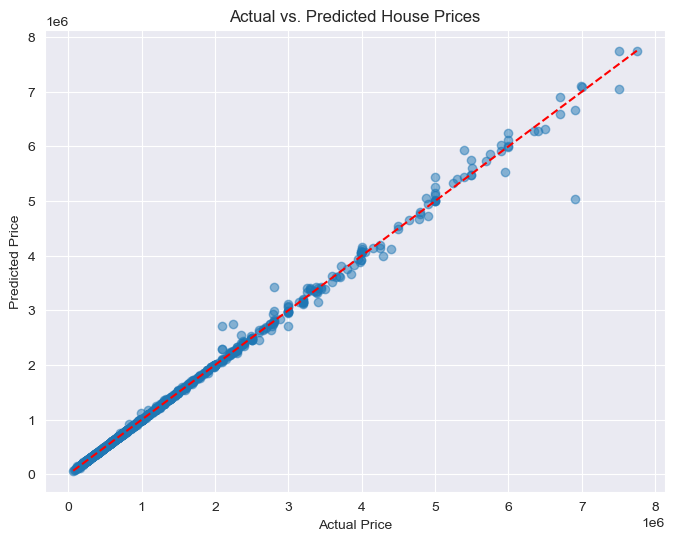

In [4481]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted House Prices')
plt.show()

### FEATURES PERFORMANCE VISUALIZATION

In [4482]:
!pip install shap --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


PermutationExplainer explainer: 3197it [37:18,  1.42it/s]                          
/var/folders/rb/8y6my9n97ms5wwj0qv5wfk4h0000gn/T/ipykernel_99074/1957051221.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_final)


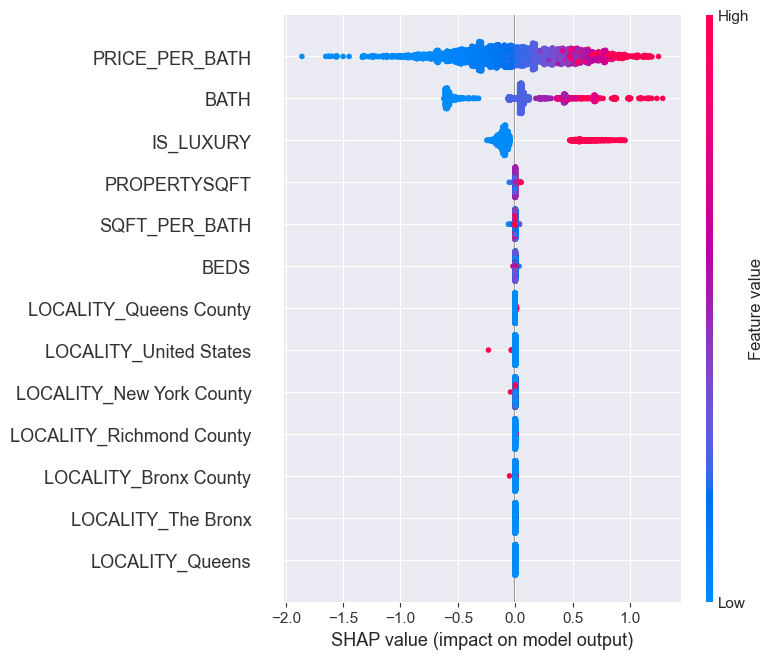

In [4483]:
import shap

explainer = shap.Explainer(stacked_model.predict, X_train_final)
shap_values = explainer(X_train_final)
shap.summary_plot(shap_values, X_train_final)

## MODEL AND TRAINED DATASET SAVING

In [4484]:
import joblib

joblib.dump(stacked_model, 'model.pkl')
joblib.dump(X_train_final, 'X_train_final.pkl')
# model = joblib.load('model.pkl')

['X_train_final.pkl']